In [1]:
from typing import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Note, for following 4 tasks, instances are still contaminated (due to clean and binarize resulting in different orders):
swedish_to_german_proverb
real_or_fake_text
strange_stories
emojis_emotion_prediction

/tmp/ipykernel_1848660/3891704393.py:44: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  avg = data.mean()
/tmp/ipykernel_1848660/3891704393.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(total)
/tmp/ipykernel_1848660/3891704393.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(avg, ignore_index=True)


<BarContainer object of 47 artists>
task-static: 0.72


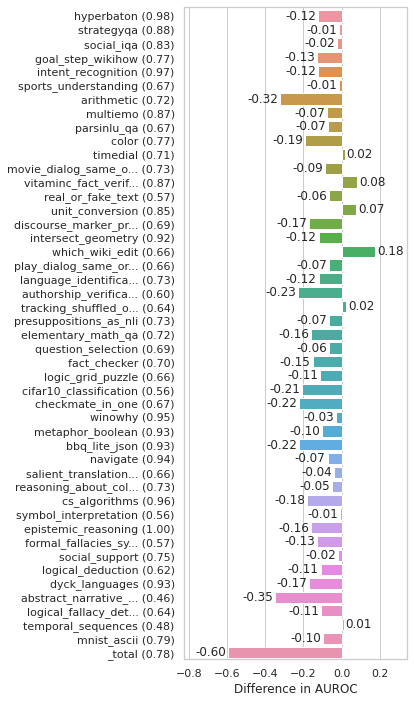

In [11]:
def prepare(df: pd.DataFrame):
    df = df.rename(columns={df.columns[0]: 'task'})
    df = df[df['test_conf_normalized_roc_auc'] > 0.1]
    df = df[df['count'] > 100]
    df = df.sort_values(by='task')
    df = df.reset_index(drop=True)
    return df

pop = pd.read_csv('../artifacts/csv-results/population/results-base-top4-128b-only.csv')
ref = pd.read_csv('../artifacts/csv-results/scaling-0sh/128b.csv')
pop = prepare(pop)
ref = prepare(ref)
ref = ref.loc[ref['task'].isin(pop['task'])]
pop = pop.loc[pop['task'].isin(ref['task'])]
ref = ref.reset_index(drop=True)
pop = pop.reset_index(drop=True)

assert all(pop.task == ref.task)

Baseline = Literal['normalized', 'absolute', 'distribution']

def shorten(x, length=15):
    if len(x) > length:
        return x[:length-3] + "..."
    else:
        return x

def plot(pop: pd.DataFrame, ref: pd.DataFrame, baseline: Baseline = "normalized", metric: str = "roc_auc"):
    sns.set_theme(style="whitegrid")
    task_system_col = f"test_conf_{baseline}_{metric}"
    assessor_col = f"test_{metric}"

    data = pd.DataFrame()
    data['task'] = pop['task']
    data['count'] = pop['count']
    data['diff'] = pop[assessor_col] - ref[assessor_col]
    data['ref'] = ref[assessor_col]
    data['pop'] = pop[assessor_col]

    data.sort_values(by="diff", inplace=True)

    total = data[data['task'] == '_total']
    data = data[data['task'] != '_total']
    data = data.append(total)

    plt.figure(figsize=(4,12))

    y = data.apply(lambda x: f"{shorten(x['task'], length=22)} ({x['ref']:.2f})", axis=1)
    p = sns.barplot(y=y, x="diff", data=data, orient='h')

    for i in p.containers:
        print(i)
        p.bar_label(i,fmt='%.2f', label_type='edge', padding=2)
    p.set_xlim(p.get_xlim()[0]*1.3, p.get_xlim()[1]*1.6)
    p.set_ylim(p.get_ylim()[0]*1.0, p.get_ylim()[1]*1.3)

    p.set_xlabel("Difference in AUROC")
    print("task-static: {:.2f}".format(pop.loc[pop.task == '_total'][f'test_conf_distribution_{metric}'][0]))
    plt.savefig(f'../artifacts/plots/population.svg', bbox_inches='tight', format='svg')

#     # return data

plot(pop, ref, metric="roc_auc")

In [3]:
# TODO: Is total present?